In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words
from wordcloud import WordCloud
import nltk
from nltk.stem import PorterStemmer
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

In [8]:
data=pd.read_csv('dataset/amazon_alexa.tsv',delimiter='\t',quoting=3)
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [9]:
data[data['verified_reviews'].isna()==True]
data.dropna(inplace=True)

In [10]:
data['length']=data['verified_reviews'].apply(len)


In [11]:
len(data.loc[0]['variation'])
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

### # # Analyzing Rating Column


In [39]:
print(f"Rating Values count: \n {data['rating'].value_counts()}")


Rating Values count: 
 rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


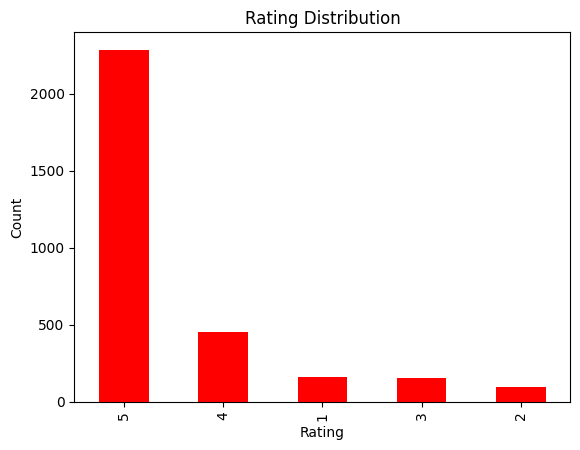

In [48]:
#Bar plot
data['rating'].value_counts().plot(kind='bar',color='red')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [51]:
#percentage of rating
data['rating'].value_counts(normalize=True)*100

rating
5    72.594474
4    14.449031
1     5.112734
3     4.826929
2     3.016831
Name: proportion, dtype: float64

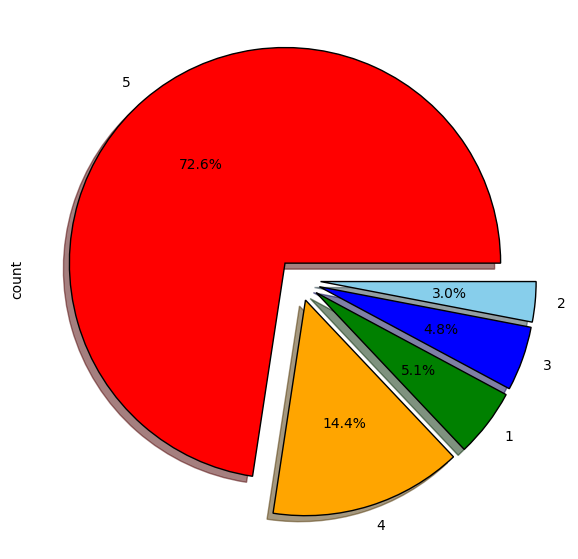

In [55]:
fig=plt.figure(figsize=(7,7))
colors=('red','orange','green','blue','skyblue')
wp={'linewidth':1,'edgecolor':'black'}
tags=data['rating'].value_counts()/data.shape[0]
explode=(0.1,0.1,0.1,0.1,0.1)
tags.plot.pie(autopct='%1.1f%%',explode=explode,colors=colors,wedgeprops=wp,shadow=True,labels=tags.index)
from io import BytesIO
graph=BytesIO()
fig.savefig(graph,format='png')

### Analyzing Feedback Column

In [62]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

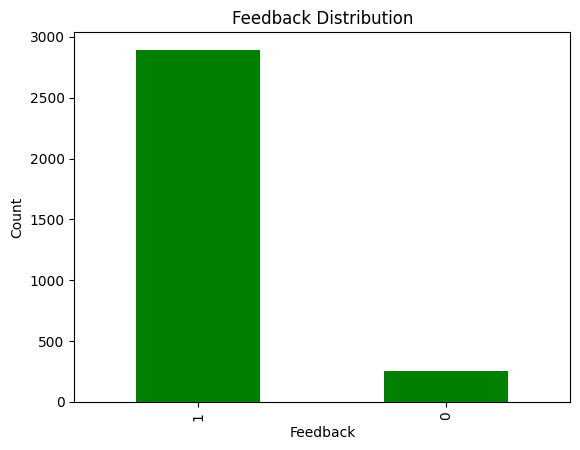

In [66]:
data['feedback'].value_counts().plot(kind='bar',color='green')
plt.title('Feedback Distribution')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [67]:
#percentage of feedback
data['feedback'].value_counts(normalize=True)*100

feedback
1    91.870435
0     8.129565
Name: proportion, dtype: float64

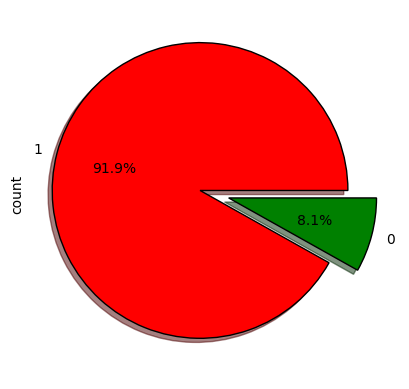

In [68]:
plt.Figure(figsize=(7,7))
colors=('red','green')
wp={'linewidth':1,'edgecolor':'black'}
tags=data['feedback'].value_counts()/data.shape[0]
explode=(0.1,0.1)
tags.plot.pie(autopct='%1.1f%%',explode=explode,colors=colors,wedgeprops=wp,shadow=True,labels=tags.index)
plt.show()
from io import bytesIO
graph=BytesIO()
fig.savefig(graph,format='png')

In [73]:
data[data['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

### Analyzing Variation

In [76]:
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

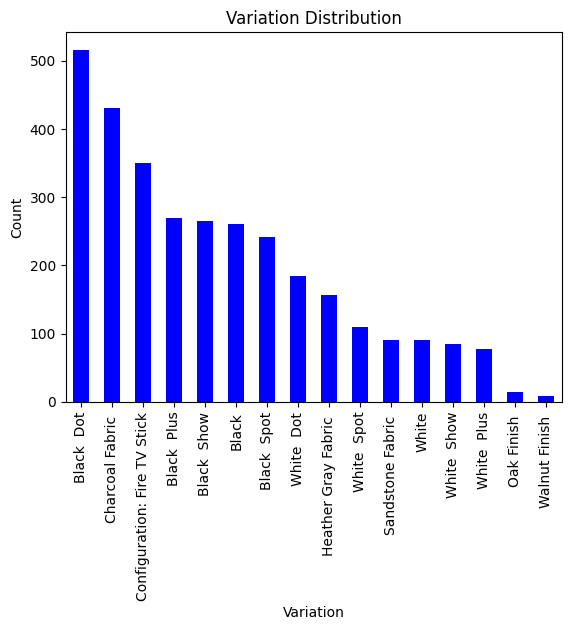

In [78]:
data['variation'].value_counts().plot(kind='bar',color='blue')
plt.title('Variation Distribution')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [79]:
data['variation'].value_counts(normalize=True)*100

variation
Black  Dot                      16.386154
Charcoal Fabric                 13.655129
Configuration: Fire TV Stick    11.114640
Black  Plus                      8.574151
Black  Show                      8.415370
Black                            8.288346
Black  Spot                      7.653223
White  Dot                       5.843125
Heather Gray Fabric              4.985710
White  Spot                      3.461416
Sandstone Fabric                 2.858050
White                            2.858050
White  Show                      2.699270
White  Plus                      2.476977
Oak Finish                       0.444586
Walnut Finish                    0.285805
Name: proportion, dtype: float64

In [82]:
data.groupby('variation')['rating'].value_counts()

variation    rating
Black        5         176
             4          35
             1          30
             3          15
             2           5
                      ... 
White  Spot  5          73
             4          18
             1           9
             3           6
             2           3
Name: count, Length: 73, dtype: int64

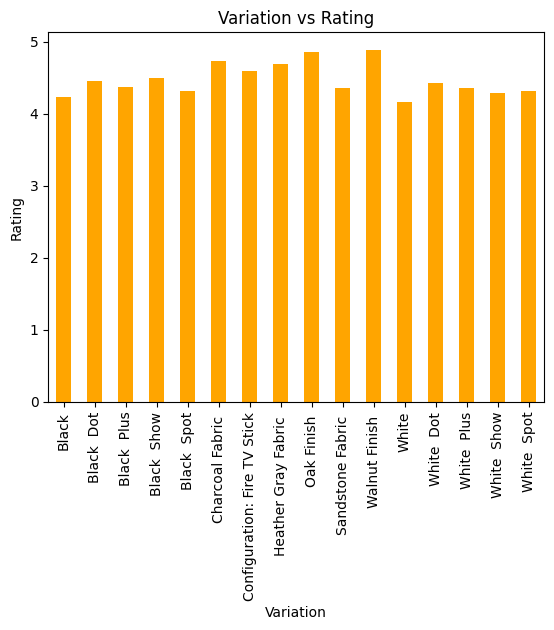

In [83]:
data.groupby('variation')['rating'].mean().plot(kind='bar',color='orange')  
plt.title('Variation vs Rating')
plt.xlabel('Variation')
plt.ylabel('Rating')
plt.show()

### Analyze verified Reviews

In [84]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of Length of Reviews')]

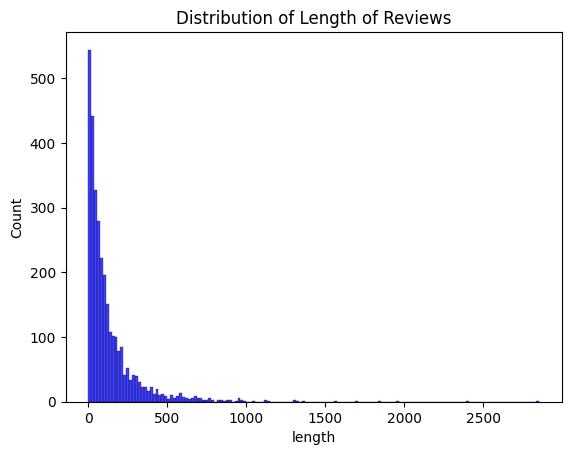

In [87]:
sns.histplot(data['length'],color='blue').set(title='Distribution of Length of Reviews')   

<Axes: ylabel='Frequency'>

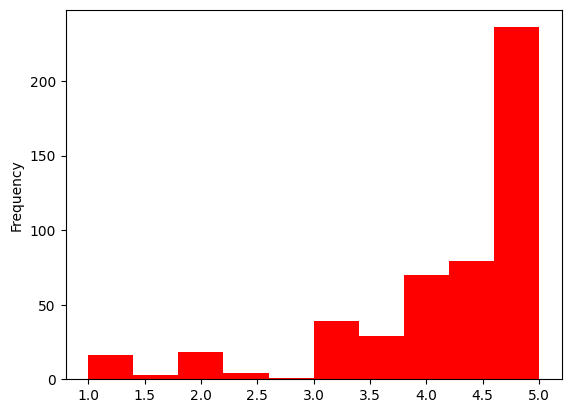

In [97]:
data.groupby('length')['rating'].mean().plot(kind='hist',color='red')

In [12]:
cv=CountVectorizer(stop_words='english')    
words=cv.fit_transform(data['verified_reviews'])

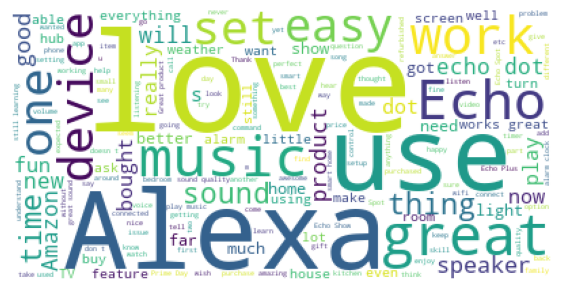

In [13]:
reviews=''.join([review for review in data['verified_reviews']])
wc=WordCloud(background_color='white',max_words=200)
plt.figure(figsize=(7,7))
plt.imshow(wc.generate(reviews))
plt.axis('off')
plt.show()

In [113]:
neg_review=''.join([review for review in data[data['feedback']==0]['verified_reviews']])
neg_review=neg_review.lower().split()
pos_review=''.join([review for review in data[data['feedback']==1]['verified_reviews']])
pos_review=pos_review.lower().split()
unique_negative=[x for x in neg_review if x not in pos_review]
unique_negative=' '.join(unique_negative)
unique_positive=[x for x in pos_review if x not in neg_review]
unique_positive=' '.join(unique_positive)

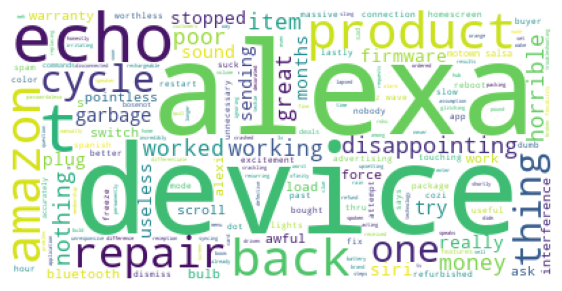

In [114]:
wc=WordCloud(background_color='white',max_words=200)
plt.figure(figsize=(7,7))
plt.imshow(wc.generate(unique_negative))
plt.axis('off')
plt.show()


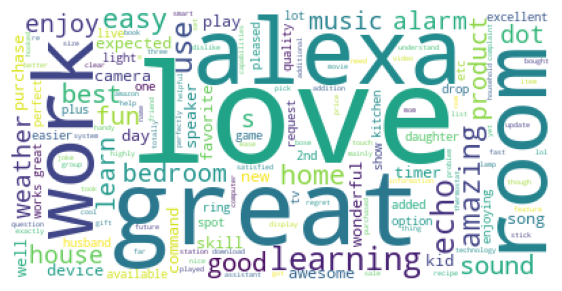

In [115]:
WC=WordCloud(background_color='white',max_words=200)
plt.figure(figsize=(7,7))
plt.imshow(WC.generate(unique_positive))
plt.axis('off')
plt.show()

In [14]:
corpus=[]
stemmer=PorterStemmer()
for i in range(0,data.shape[0]):
    review=data.iloc[i]['verified_reviews']
    review=str(review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review=review.lower()
    review=review.split()
    review=[stemmer.stem(word) for word in review if not word in stop_words]
    review=' '.join(review)
    corpus.append(review)

In [38]:
print(corpus)

['love echo', 'love', 'play game answer question correctli alexa say got wrong answer like abl turn light away home', 'lot fun thing yr old learn dinosaur control light play game like categori nice sound play music', 'music', 'receiv echo gift need bluetooth play music easili access smart speaker t wait', 'have cellphon use featur ipad use great alarm u r deaf hear alarm bedroom live room reason fun ask random question hear respons doe smartbon polit', 'think th ve purchas m work get room hous realli like featur offer specifili play music echo control light hous', 'look great', 'love ve listen song haven t heard childhood news weather inform s great', 'sent year old dad talk constantli', 'love learn knew thing eveyday figur work far s easi use understand doe make laugh time', 'purchas mother have knee problem tri come get fast like did enjoy littl big thing alexa play song time cook', 'love love love', 'just expect', 'love wife hate', 'realli happi purchas great speaker easi set', 'use

In [15]:
cv=CountVectorizer(max_features=2500)
x=cv.fit_transform(corpus).toarray()
y=data['feedback'].values

In [16]:
pickle.dump(cv,open('Models/cv.pkl','wb'))

In [17]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=15)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2204, 2500)
(945, 2500)
(2204,)
(945,)


In [19]:
scaler=MinMaxScaler()
x_train_scaled=scaler.fit_transform(X_train)
x_test_scaled=scaler.transform(X_test)

In [20]:
pickle.dump(scaler,open('Models/scaler.pkl','wb'))

Random Forest

In [21]:
model_rf=RandomForestClassifier()
model_rf.fit(x_train_scaled,y_train)

RandomForestClassifier()

In [23]:
model_rf.score(x_train_scaled,y_train)
model_rf.score(x_test_scaled,y_test)

0.944973544973545

In [24]:
y_pred=model_rf.predict(x_test_scaled)

In [27]:
cm=confusion_matrix(y_test,y_pred)

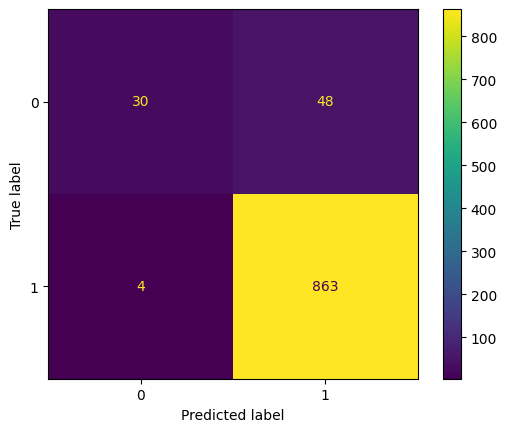

In [29]:
cm_display=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [32]:
accuracies=cross_val_score(estimator=model_rf,X=x_train_scaled,y=y_train,cv=10)
print(accuracies.mean())
print(accuracies.std())

0.9305841217605924
0.010540812271722495


In [33]:
params={
    'bootstrap': [True, False],
    'max_depth': [80,100],
    'min_samples_split': [8,12],
    'n_estimators': [100,300]
}

In [41]:
cv_object=StratifiedKFold(n_splits=2)
grid_search=GridSearchCV(estimator=model_rf,param_grid=params,cv=cv_object,verbose=0,return_train_score=True)
grid_search.fit(x_train_scaled,y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [42]:
print("Best Parameters:{} ".format(grid_search.best_params_))

Best Parameters:{'bootstrap': False, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 300} 


In [45]:
print("cross_val_score train set:{}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("cross_val_score test set:{}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy:{}",accuracy_score(y_test,y_pred)





cross_val_score test set:92.35197368421053
cross_val_score train set:97.8391560798548
